Instalar Qiskit e importar as bibliotecas necessárias, incluindo numpy e pandas

In [ ]:
train_name = "model_train_name"

In [1]:
!pip install qiskit pylatexenc qiskit_algorithms qiskit_machine_learning matplotlib


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Separar datasets de treinamento e teste, separar as features que serão utilizadas.
Preencher nan com a média de valores da coluna.  // Testar também normalização [0;pi]

In [3]:
import numpy as np
import pandas as pd

In [4]:
train = pd.read_csv("./train_normalized.csv")
test = pd.read_csv("./test_normalized.csv")

In [5]:
y_train = train['label']
y_test = test['label']

## FEATURE SELECTION

In [6]:
selected_features = ["proto", "orig_bytes", "conn_state", "resp_pkts", "resp_ip_bytes"]
num_features = len(selected_features)

In [7]:
train = train[selected_features]
test = test[selected_features]

In [8]:
train.head(5)

,proto,orig_bytes,conn_state,resp_pkts,resp_ip_bytes
0,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
1,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
2,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
3,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
4,0.5,2.382635e-07,0.833333,0.000017,6.178160e-07


Definir o Label para treinamento (característica que se quer prever)

## FEATURE MAP

- [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap): Aplica portas Hadamard (H) e rotações Pauli-Z parametrizadas (Z), seguidas de interações de entrelaçamento (por exemplo, portas CX e rotações ZZ).
- [ZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZFeatureMap): Circuito mais simples, com repetições de camadas de portas H e Z em cada qubit, sem interações entre eles.
- [PauliFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliFeatureMap): Classe base para feature maps que utilizam operações Pauli (como Z, X, Y) para codificação.

### ZZ FEATURE MAP

In [9]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(num_features, reps = 1)

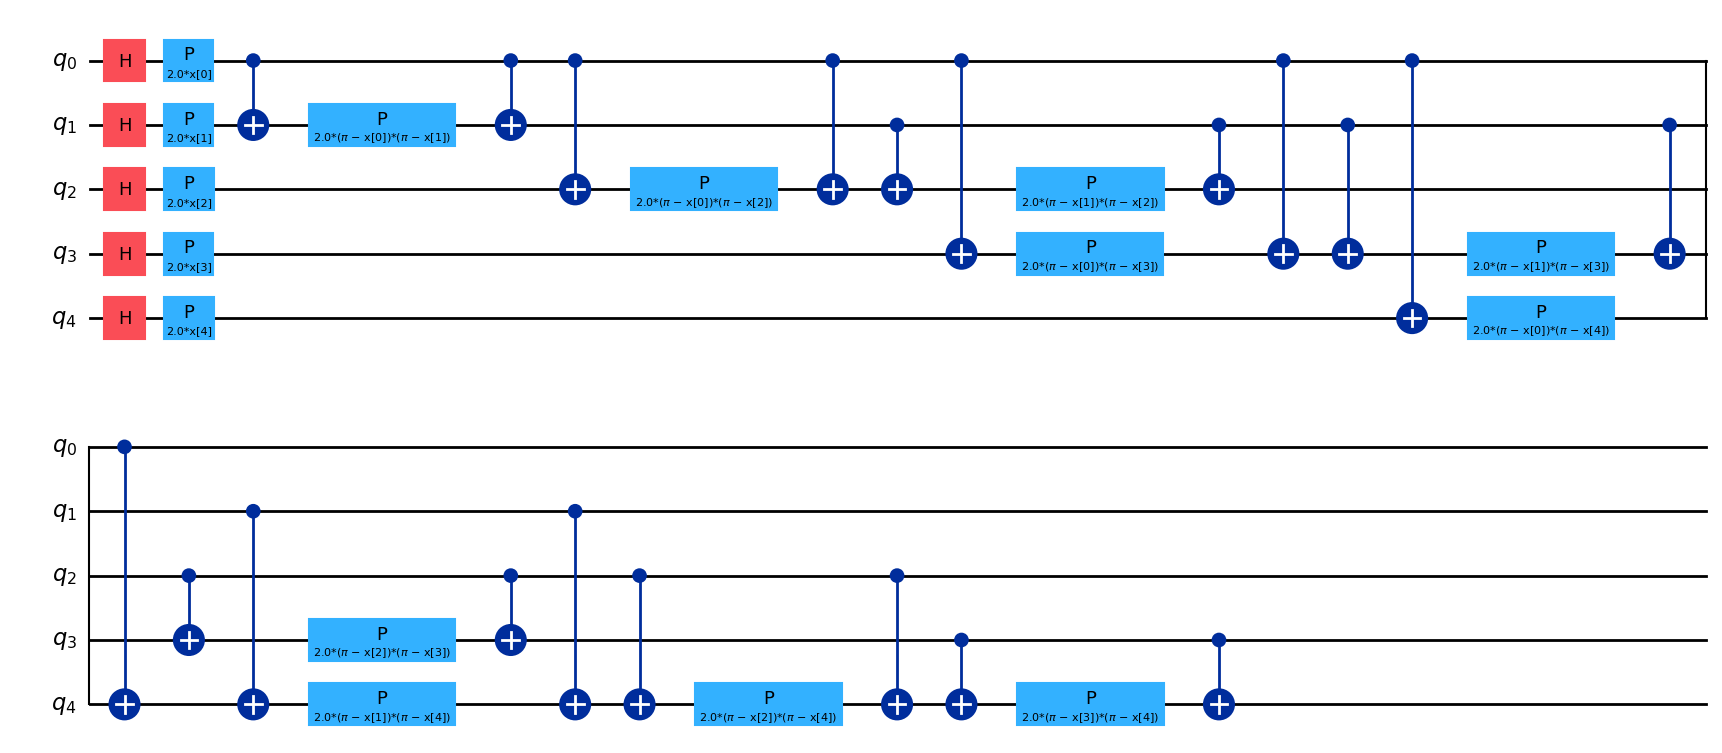

In [10]:
feature_map.decompose().draw(output = "mpl", fold = 25)

### YY Pauli Feature Map

In [ ]:
from qiskit.circuit.library import PauliFeatureMap

feature_map = PauliFeatureMap(num_features, reps = 1, paulis=["YY"])

### XX Pauli Feature Map

In [ ]:
from qiskit.circuit.library import PauliFeatureMap

feature_map = PauliFeatureMap(num_features, reps = 1, paulis=["XX"])

## Ansatz

#### [TwoLocal](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal)


In [11]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_features, reps = 2)

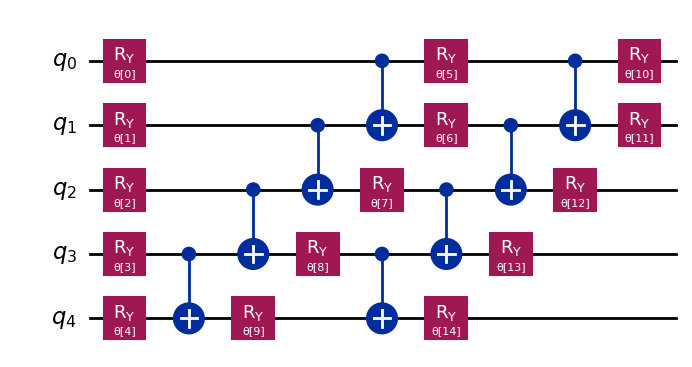

In [12]:
ansatz.decompose().draw(output = "mpl", fold = 40)

### [Hamiltonian Variational Ansatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.hamiltonian_variational_ansatz)

## OTIMIZADORES

#### [COBYLA](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.COBYLA.html#qiskit_machine_learning.optimizers.COBYLA)

In [13]:
from qiskit_algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)

### [ADAM](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.ADAM.html#qiskit_machine_learning.optimizers.ADAM)

### [POWELL](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.POWELL.html#qiskit_machine_learning.optimizers.POWELL)

### [SPSA](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.SPSA.html#qiskit_machine_learning.optimizers.SPSA)

## SAMPLER
Erro no VQC, checar motivo

Importar Sampler, shots=512 -> https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler

In [14]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

## Callback Function
Importar pyplot para plotar gráfico da função custo pelas iterações - callback_graph

In [15]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"]= (12,6)

def callback_graph(weight, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Função de Custo")
    plt.xlabel("Iterações")
    plt.ylabel("Função de Custo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


## VQC
Importar classificador VQC do Qiskit -> https://github.com/qiskit-community/qiskit-machine-learning // https://qiskit-community.github.io/qiskit-machine-learning/getting_started.html#installation

VQC { sampler = sampler; feature_map = feature_map, ansatz = ansatz; optimizer = optimizer; callback = callback_graph }

Importar time para visualizar o tempo de execução

VQC.fit(train_features, train_labels.values)

In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    #sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals= []
start = time.time()
vqc.fit(train, y_train.values)
elapsed = time.time() - start

vqc.save(f'trained_models/{train_name}.model')

print(f"Training time: {round(elapsed)} seconds")

Training time: 23631 seconds


In [17]:
train_acc = vqc.score(train, y_train)
print(f'Acuracia: {round(train_acc,2)*100}%')

Acuracia: 95.0%


Rodar com o teste -> VQC.predict(test);

Realizar avaliação dos resultados (acurácia, precisão, recall...)

In [18]:
y_predicted = vqc.predict(test)

y_predicted

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      6575
         1.0       0.93      1.00      0.96     13655

    accuracy                           0.95     20230
   macro avg       0.96      0.92      0.94     20230
weighted avg       0.95      0.95      0.94     20230



In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
print(confusion_matrix)

[[ 5477  1098]
 [    0 13655]]


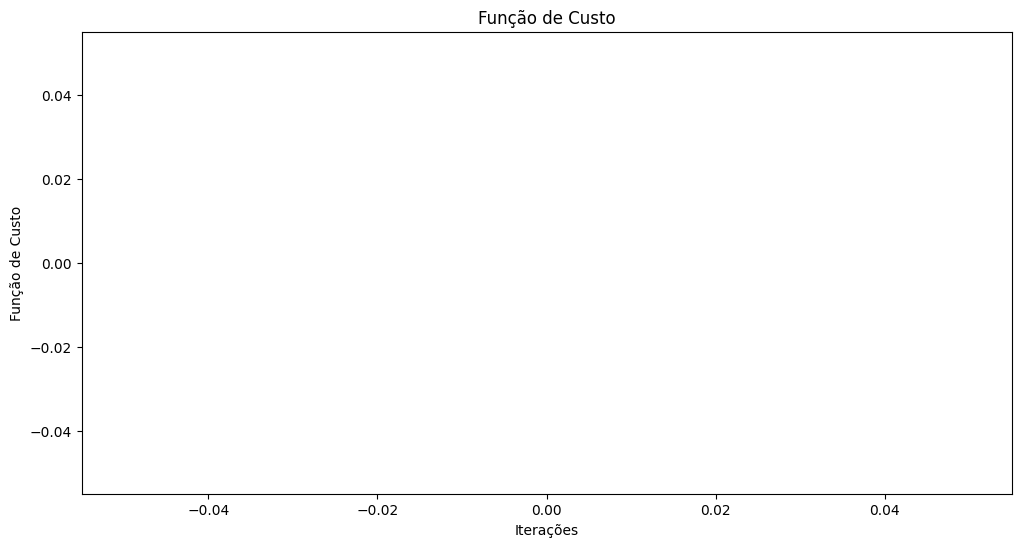

In [22]:
plt.title("Função de Custo")
plt.xlabel("Iterações")
plt.ylabel("Função de Custo")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [21]:
from pandas import DataFrame

from google.colab import drive
drive.mount('/content/gdrive')

df = DataFrame(y_predicted)
df.to_csv('/content/gdrive/y_predicted.csv', index=False)

ModuleNotFoundError: No module named 'google.colab'